训练集标注可视化

In [10]:
%config InlineBackend.figure_format = 'retina'

In [11]:
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from glob import glob
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm



# 按行生成彩色标注框
idx2color = []
for i in range(3):
    for j in range(3):
        for k in range(3):
            idx2color.append((i*100, j*100, k*100))
idx2color = np.array(idx2color)


def table_visualize(src_img, table, key='row'):
    for idx, row in enumerate(table[key]):
        color = idx2color[idx] if idx < len(idx2color) else idx2color[-1]
        pts = np.array(row, dtype=np.int32)
        temp_img = src_img.copy()
        cv2.polylines(temp_img, [pts], True, color.tolist(), 2)

        cx, cy = pts.mean(axis=0)
        twidth, theight = cv2.getTextSize(str(idx), cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
        cv2.putText(temp_img, str(idx), (int(cx-twidth/2), int(cy-theight/2)), cv2.FONT_HERSHEY_SIMPLEX, 1, color.tolist(), 2)
        temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
        plt.imshow(temp_img)
        plt.show()

def label_visualize(src_img, label):
    for cell in label['cells']:
        start_row_idx = cell['row_start_idx']
        end_row_idx   = cell['row_end_idx']
        start_col_idx = cell['col_start_idx']
        end_col_idx   = cell['col_end_idx']
        color = idx2color[start_row_idx] if start_row_idx < len(idx2color) else idx2color[-1]
        x0, y0, x1, y1 = cell['bbox']

        pts = np.array(cell['segmentation'], dtype=np.int32)
        cv2.rectangle(src_img, (int(x0), int(y0)), (int(x1), int(y1)), color.tolist(), 1)

        theight = cv2.getTextSize(str(start_row_idx), cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0][1]
        show_text = f"{start_row_idx}" if start_row_idx == end_row_idx else f"{start_row_idx}-{end_row_idx}"
        show_text += f",{start_col_idx}" if start_col_idx == end_col_idx else f" {start_col_idx}-{end_col_idx}"

        # cv2.putText(src_img, show_text, (int(x0), int(y0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 1)
        transcript = cell['transcript']
        cv2.putText(src_img, transcript, (int(x0), int(y0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 1)
        plt.imshow(src_img)
    plt.show()

def rotate_label_visualize(src_img, label):
    h, w = src_img.shape[:2]
    center = (w//2, h//2)
    M = cv2.getRotationMatrix2D(center, -1, 1.0)
    src_img = cv2.warpAffine(src_img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    # src_img = cv2.warpAffine(src_img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

    for cell in label['cells']:
        start_row_idx = cell['row_start_idx']
        end_row_idx   = cell['row_end_idx']
        start_col_idx = cell['col_start_idx']
        end_col_idx   = cell['col_end_idx']
        color = idx2color[start_row_idx] if start_row_idx < len(idx2color) else idx2color[-1]
        x0, y0, x1, y1 = cell['bbox']
        [x0, y0], [x1, y1] = cv2.transform(np.array([[[x0, y0], [x1, y1]]]), M).squeeze().astype(np.int32)

        pts = np.array(cell['segmentation'], dtype=np.int32)
        cv2.rectangle(src_img, (int(x0), int(y0)), (int(x1), int(y1)), color.tolist(), 1)

        theight = cv2.getTextSize(str(start_row_idx), cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0][1]
        show_text = f"{start_row_idx}" if start_row_idx == end_row_idx else f"{start_row_idx}-{end_row_idx}"
        show_text += f",{start_col_idx}" if start_col_idx == end_col_idx else f" {start_col_idx}-{end_col_idx}"

        cv2.putText(src_img, show_text, (int(x0), int(y0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 1)
        plt.imshow(src_img)
    plt.show()





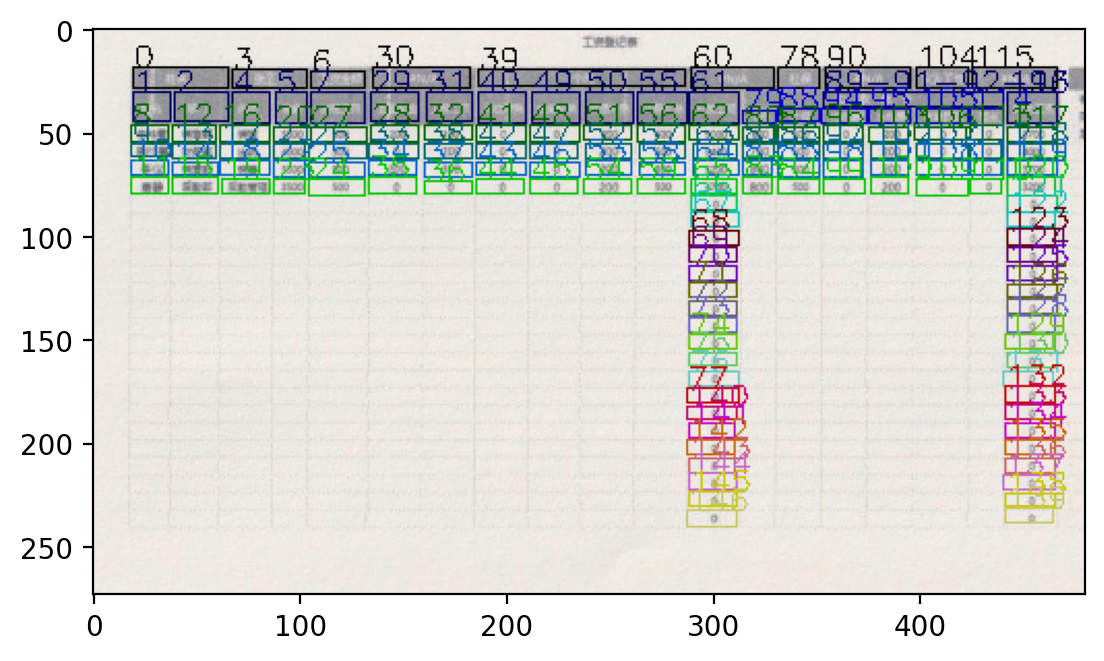

In [12]:
import utils.table2label as table2label
'''
可视化单一图像
'''
img_id = '07001'
jpg_path  = f"/media/ubuntu/Date12/TableStruct/new_data/train_jpg480max/{img_id}.jpg"
json_path = f"/media/ubuntu/Date12/TableStruct/new_data/train_jpg480max/{img_id}.json"

src_img = cv2.imread(jpg_path)
table = json.load(open(json_path, 'r'))

# if not table2label.table_valid(table):
#     print("table_valid error!", img_id)
# # table = table2label.fix_table_error(table)

# table_visualize(src_img, table, 'row')
label = table2label.table2label(table)
label_visualize(src_img, label)
# rotate_label_visualize(src_img, label)

for i in range(100):
    break
    img_id = f'{i:05d}'
    jpg_path  = f"/media/ubuntu/Date12/TableStruct/data/train_jpg/{img_id}.jpg"
    json_path = f"/media/ubuntu/Date12/TableStruct/data/train_jpg/{img_id}.json"

    src_img = cv2.imread(jpg_path)
    table = json.load(open(json_path, 'r'))

    table = table2label.fix_table_error(table)

    if  not table2label.table_valid(table):
        print("table_valid error!", img_id)
        continue

    # table_visualize(src_img, table, 'row')
    label = table2label.table2label(table)
    if not table2label.table2label_valid(table, label):
        num_row = len(table['row'])
        num_col = len(table['col'])
        num_row_layout = len(label['layout'])
        num_col_layout = len(label['layout'][-1])
        if num_row != num_row_layout:
            print(f"{img_id}:", "table row: ", num_row, "label row:", num_row_layout)
        if num_col != num_col_layout:
            print(f"{img_id}", "table col: ", num_col, "label col:", num_col_layout)
        # print("not valid!!!", img_id)
    # label_visualize(src_img, label)

